In [49]:
import numpy as np
import torch
import torch.nn as nn

import pandas as pd


batch_size = 128
hidden_size1 = 150
hidden_size2 = 100
hidden_size3 = 50
max_epoch = 100

In [2]:
df = pd.read_csv('./archive/UNSW_NB15_training-set.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [3]:
Y = df.label
X = df.drop(columns=['id','attack_cat','label'])
mask = (X.dtypes == np.object)

list_cat = X.loc[:,mask].columns.tolist()

X = pd.get_dummies(X, columns=list_cat)
X.head()

C:\Users\ajou\AppData\Local\Temp/ipykernel_12520/47757013.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (X.dtypes == np.object)


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto_3pc,...,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
0,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [91]:
from torch.utils.data import DataLoader

class UNSW_Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.data = X
        self.label = y
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.data.iloc[idx]), torch.FloatTensor([self.label.iloc[idx]])


train_dataset = UNSW_Dataset(X_train, y_train)
test_dataset = UNSW_Dataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size = batch_size)


MLP

In [88]:
model = nn.Sequential(
    nn.Linear(len(X_train.columns), hidden_size1),
    nn.LeakyReLU(),
    nn.Linear(hidden_size1, hidden_size2),
    nn.LeakyReLU(),
    nn.Linear(hidden_size2, hidden_size3),
    nn.LeakyReLU(),
    nn.Linear(hidden_size3, 1),
    nn.Sigmoid()
)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())


In [99]:
device = torch.device('cuda')

model.to(device)
losses = []
for epoch in range(max_epoch) :

    sum = 0

    for batch_x, batch_y in train_loader :

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        pred_y = model(batch_x)
        loss = loss_function(pred_y, batch_y)
        loss.backward()
        optimizer.step()
        sum += loss
        

    print(f"{epoch + 1}/{max_epoch} / loss : {sum/len(train_loader):.4f}")
    losses.append(sum/len(train_loader))


1/100 / loss : 41.2512
2/100 / loss : 42.9873
3/100 / loss : 43.0256
4/100 / loss : 44.4250
5/100 / loss : 44.7930
6/100 / loss : 43.1187
7/100 / loss : 37.8047
8/100 / loss : 40.2119
9/100 / loss : 39.6464
10/100 / loss : 34.5452
11/100 / loss : 29.8730
12/100 / loss : 29.8799
13/100 / loss : 29.6763
14/100 / loss : 29.6763
15/100 / loss : 29.6763
16/100 / loss : 29.6874
17/100 / loss : 29.7018
18/100 / loss : 29.7019
19/100 / loss : 29.7019
20/100 / loss : 29.7018
21/100 / loss : 29.7016
22/100 / loss : 29.7018
23/100 / loss : 29.7016
24/100 / loss : 29.7018
25/100 / loss : 29.7019
26/100 / loss : 30.5470
27/100 / loss : 29.6894
28/100 / loss : 30.7187
29/100 / loss : 31.4843
30/100 / loss : 31.4842
31/100 / loss : 31.4850
32/100 / loss : 31.4843
33/100 / loss : 31.4842
34/100 / loss : 31.4843
35/100 / loss : 31.4842
36/100 / loss : 31.4842
37/100 / loss : 31.4842
38/100 / loss : 31.4842
39/100 / loss : 31.4842
40/100 / loss : 31.4845
41/100 / loss : 31.4842
42/100 / loss : 31.4842
4

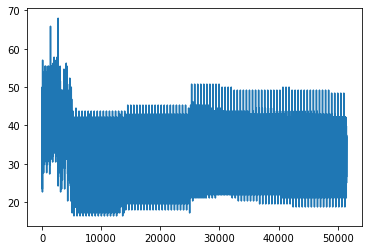

In [104]:
import matplotlib.pyplot as plt


plt.plot(losses)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score


with torch.no_grad():
    model.eval()

    y_pred = model()


accuracy_score(y_true, y_pred)

